In [ ]:
import os
import glob
import sys
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from Classifications import Classifications

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks
from sklearn.preprocessing import StandardScaler

In [ ]:
seed = 42
rng = np.random.default_rng(seed=seed)
classifications = Classifications()

In [ ]:
def get_classes():
    classes_list = []
    for stroke, side, spin in classifications.classes:
        classes_list.append(f"{stroke}_{side}_{spin}")
    #print(classes_list)
    return classes_list

In [ ]:
def concatenate_dfs(folder_path):
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = []
    for filename in all_files:
        df = pd.read_csv(filename)
        df_list.append(df)

    concatenated_df = pd.concat(df_list, ignore_index=True)
    return concatenated_df

In [ ]:
def separate_classes(concatenated_df):
    classes_list = get_classes()
    all_df = concatenated_df.copy()

    all_df["stroke_side_spin"] = all_df["stroke"].astype(str).str.lower() + "_" + all_df["side"].astype(str).str.lower() + "_" + all_df["spin"].astype(str).str.lower()

    #all_df = all_df.drop(columns=["spin", "stroke", "side"])

    splits = {
        side: grp.reset_index(drop=True)
        for side, grp in all_df.groupby('stroke_side_spin') if side in classes_list
    }
    return splits

In [ ]:
# Magnitudes
def get_magnitudes(df):
    df["|a|"] = np.sqrt(df["ax"]**2 + df["ay"]**2 + df["az"]**2)
    df["|g|"] = np.sqrt(df["gx"]**2 + df["gy"]**2 + df["gz"]**2)

    plot_width = len(df) // 60
    num_xticks = len(df) // 80
    x_ticks = np.linspace(df["ms"].min(), df["ms"].max(), num=num_xticks)
    return plot_width, x_ticks

In [ ]:
# Raw data plot
def plot_raw_data(df, plot_width, x_ticks):
    plots = (
        { "label": "ax", "title": "Acceleration X", "color": "r" },
        { "label": "ay", "title": "Acceleration Y", "color": "g" },
        { "label": "az", "title": "Acceleration Z", "color": "b" },
        { "label": "gx", "title": "Gyroscope X", "color": "r" },
        { "label": "gy", "title": "Gyroscope Y", "color": "g" },
        { "label": "gz", "title": "Gyroscope Z", "color": "b" },
    )

    fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))
    for ax, plot in zip(axes, plots):
        ax.plot(df["ms"], df[plot["label"]], label=plot["title"], color=plot["color"])
        ax.set_xlabel("Milliseconds")
        ax.set_ylabel(plot["title"])
        ax.set_xticks(x_ticks)
        ax.ticklabel_format(style='plain')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Chunked Online Z-Score Normalization of Data (as would happen on Arduino)
def normalize_data(df):
    sensors = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
    normalized_sensors = [f"{col}'" for col in sensors]
    df[normalized_sensors] = np.nan

    scaler = StandardScaler()
    chunk_size = classifications.num_sensor_data_entries
    for i in range(0, len(df), chunk_size):
        j = i + chunk_size - 1
        chunk = df.loc[i:j, sensors]
        normalized_chunk = scaler.partial_fit(chunk[sensors]).transform(chunk[sensors])
        df.loc[i:j, normalized_sensors] = normalized_chunk

In [ ]:
# Normalized data plot
def plot_normalized_data(df, plot_width, x_ticks):
    plots = (
        { "label": "ax'", "title": "Normalized Acceleration X", "color": "r" },
        { "label": "ay'", "title": "Normalized Acceleration Y", "color": "g" },
        { "label": "az'", "title": "Normalized Acceleration Z", "color": "b" },
        { "label": "gx'", "title": "Normalized Gyroscope X", "color": "r" },
        { "label": "gy'", "title": "Normalized Gyroscope Y", "color": "g" },
        { "label": "gz'", "title": "Normalized Gyroscope Z", "color": "b" },
    )

    fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))

    for ax, plot in zip(axes, plots):
        label = plot["label"]
        ax.plot(df["ms"], df[label], color=plot["color"], linestyle='-')
        ax.set_xlabel("Milliseconds")
        ax.set_ylabel(f"{plot['title']} Z-Score")
        ax.set_title(plot["title"])
        ax.set_xticks(x_ticks)
        ax.ticklabel_format(style='plain')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Acceleration Squared (will be used on Arduino as threshold for shot detection)
def get_peaks(df):
    df["a^2"] = np.sum(df[["ax", "ay", "az"]].values**2, axis=1)

    # Peak detection
    peaks, _ = find_peaks(
        df["a^2"],
        height=classifications.squared_acceleration_threshold,
        distance=classifications.num_steps,
    )

    counts = (
        df.loc[peaks].groupby(["spin", "side", "stroke"], sort=False)
        .size()
        .reset_index(name="count")
    )
    print(counts.to_string(index=False))
    return peaks

In [ ]:
# Peaks plot
def plot_peaks(df, plot_width, x_ticks, peaks):
    fig, ax = plt.subplots(figsize=(plot_width, 3))
    ax.plot(df["ms"], df["a^2"], label="Squared Acceleration", color="k")
    ax.plot(df.loc[peaks, "ms"], df.loc[peaks, "a^2"], "rx", label="Peaks")
    ax.set_title("Squared Acceleration Data with Peaks")
    ax.set_xlabel("Milliseconds")
    ax.set_ylabel("Squared Acceleration")
    ax.set_xticks(x_ticks)
    ax.ticklabel_format(style='plain')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def individualize_peaks(df, plot_width, x_ticks, peaks):
    plots = (
        { "label": "ax'", "title": "Normalized Acceleration X", "color": "r", "marker": "kx" },
        { "label": "ay'", "title": "Normalized Acceleration Y", "color": "g", "marker": "rx" },
        { "label": "az'", "title": "Normalized Acceleration Z", "color": "b", "marker": "rx" },
        { "label": "a^2", "title": "Squared Acceleration", "color": "k", "marker": "rx" },
        { "label": "gx'", "title": "Normalized Gyroscope X", "color": "r", "marker": "kx" },
        { "label": "gy'", "title": "Normalized Gyroscope Y", "color": "g", "marker": "rx" },
        { "label": "gz'", "title": "Normalized Gyroscope Z", "color": "b", "marker": "rx" },
    )

    labels = [d["label"] for d in plots]

    # Plotting just the normalized detected shot data
    fig, axes = plt.subplots(len(plots), 1, figsize=(plot_width, 3 * len(plots)))

    shot_windows = []

    first = True
    for peak in peaks:
        # Random rotation for generalization
        if first:
            random_rotation = R.from_euler(seq="x", angles=180, degrees=True)
        else:
            random_rotation = R.random(random_state=rng)
        rotated_vectors = random_rotation.apply(np.identity(3))

        start_idx = max(0, peak - classifications.steps_before_peak)
        end_idx = peak + classifications.steps_after_peak

        shot_data = df.loc[start_idx:end_idx].reset_index(drop=True)
        rotated_shot_data = shot_data.copy()
        # print(len(shot_data))

        rotated_shot_data[["ax'", "ay'", "az'"]] = random_rotation.apply(shot_data[["ax'", "ay'", "az'"]].to_numpy())
        rotated_shot_data[["gx'", "gy'", "gz'"]] = random_rotation.apply(shot_data[["gx'", "gy'", "gz'"]].to_numpy())

        shot_windows.append(rotated_shot_data)

        for ax, plot in zip(axes, plots):
            ax.plot(shot_data["ms"], shot_data[plot["label"]], label="Original", color=plot["color"], alpha=0.25)
            ax.plot(rotated_shot_data["ms"], rotated_shot_data[plot["label"]], label="Rotated", color=plot["color"])
            ax.plot(rotated_shot_data.loc[classifications.steps_before_peak, "ms"], rotated_shot_data.loc[classifications.steps_before_peak, plot["label"]], plot["marker"])

            ax.set_xlabel("Milliseconds")
            ax.set_ylabel(plot["title"])

            ax.set_xticks(x_ticks)
            ax.ticklabel_format(style='plain')

            if first:
                ax.legend()
            ax.grid(True)
        first = False

    plt.tight_layout()
    plt.show()

    all_shots_df = pd.concat(shot_windows, ignore_index=True)
    return all_shots_df

In [ ]:
def process_df(df, name, output_path):

    # Plot Raw Data
    plot_width, x_ticks = get_magnitudes(df)
    print("Raw Data")
    plot_raw_data(df, plot_width, x_ticks)

    # Normalize and Plot
    normalize_data(df)
    print("Normalized Data")
    plot_normalized_data(df, plot_width, x_ticks)

    # Find and Count Peaks
    peaks = get_peaks(df)
    print(f"Peaks: {len(peaks)}")
    plot_peaks(df, plot_width, x_ticks, peaks)

    # Individualize Each Peak and Save as New CSV
    print("Individualized Peaks")
    peaks_df = individualize_peaks(df, plot_width, x_ticks, peaks)
    peaks_df.to_csv(f'./{output_path}/{name}.csv')
    # return peaks_df

Raw Data


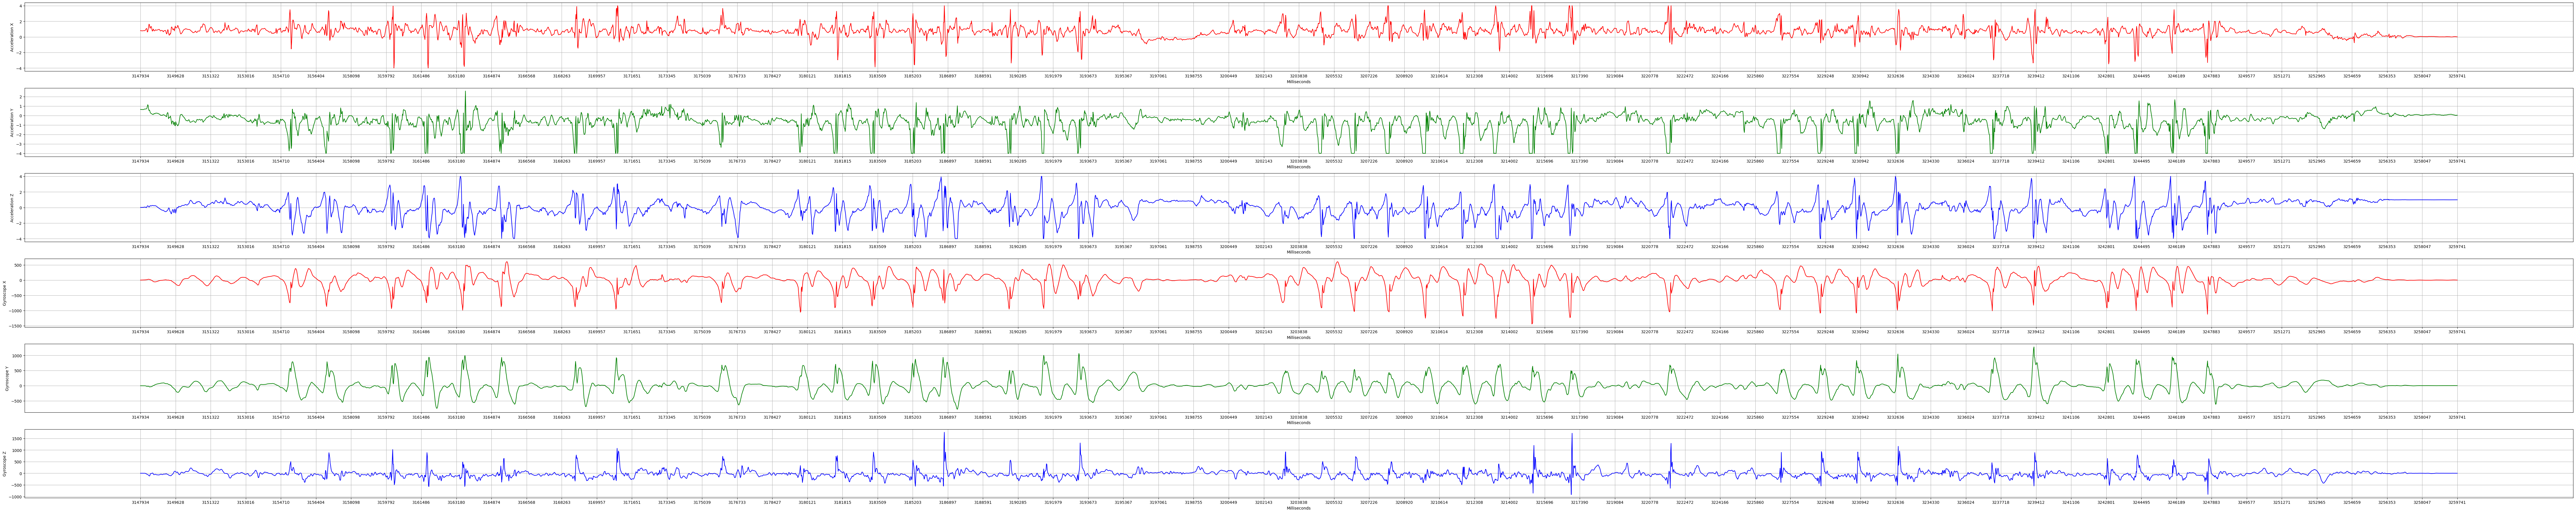

Normalized Data


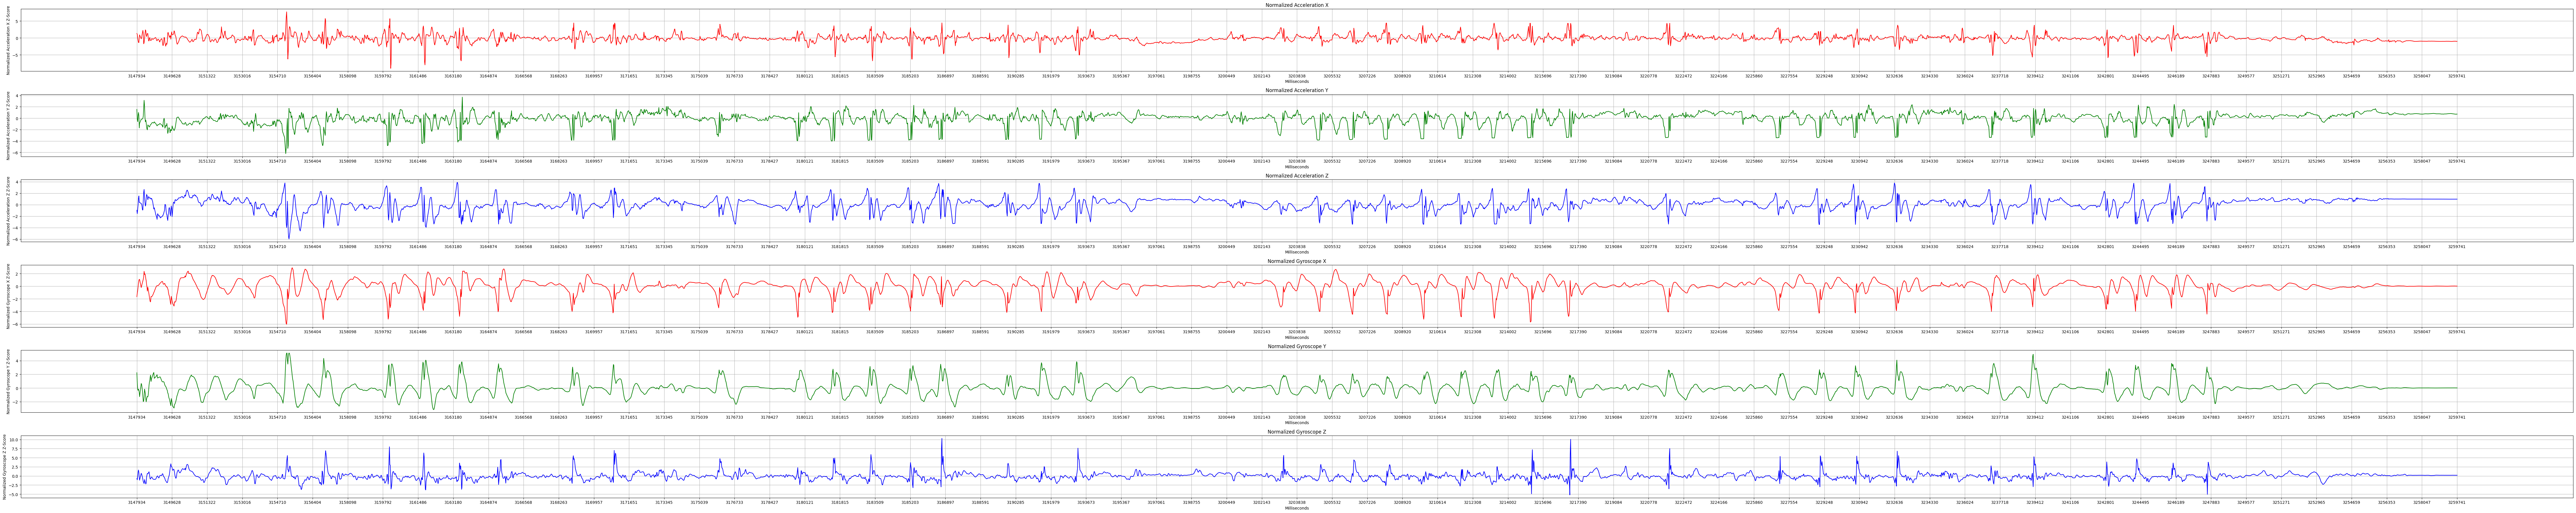

   spin     side       stroke  count
Topspin Backhand Groundstroke     36
Peaks: 36


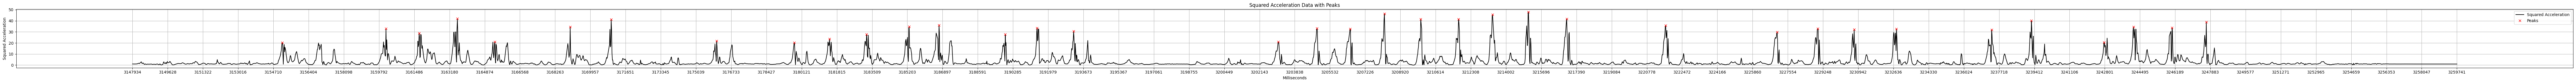

Individualized Peaks
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


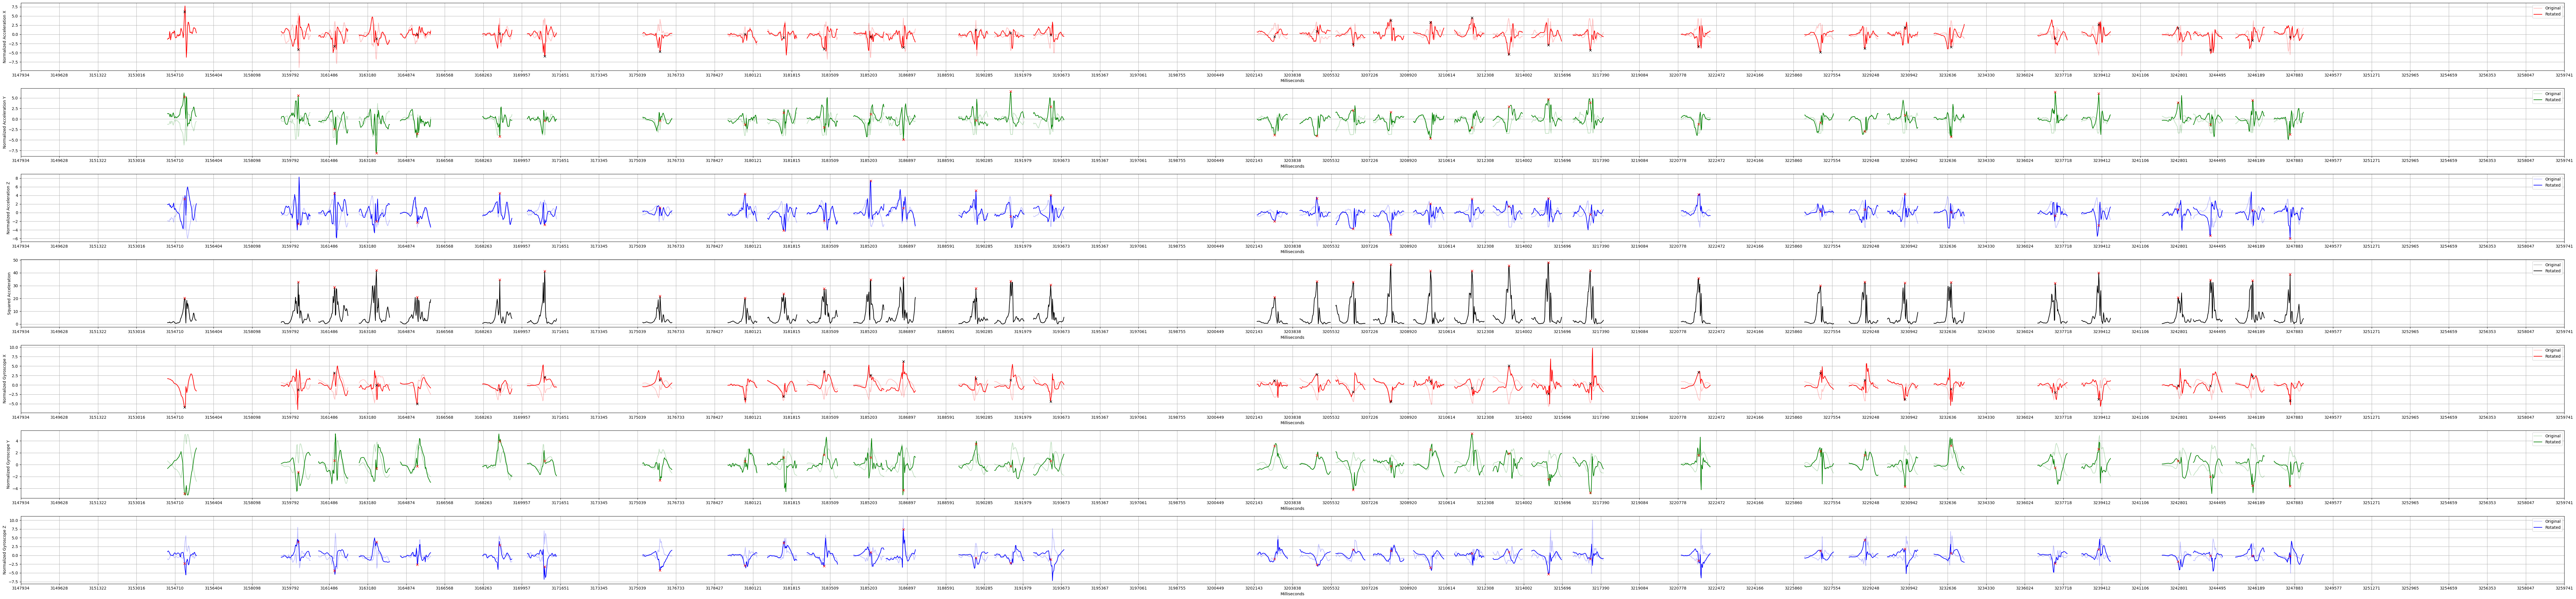

In [ ]:
input_path = "./sensor_data"
output_path = "./processed_data"

# Get and Organize All Data
concatenated_df = concatenate_dfs(input_path)
splits = separate_classes(concatenated_df)

# print(len(splits))
# df = splits["groundstroke_backhand_topspin"]
# name = "groundstroke_backhand_topspin"
# peaks_df = process_df(df, name, output_path)
# peaks_df.head(67)

for name, df in splits.items():
    print(name)

    # Process Each DF
    process_df(df, name, output_path)